<h1><center><b>Gesture Recognition</b></center></h1>

<div style="text-align: right"> Submitted By:
<br>Deepika Hariharan \ Ravi Dhir</div>

## Contents

* [1. Introduction](#1)
 * [1.1 Import the Libraries](#1.1)
* [2. Generator](#2)
 * [2.1 Defining CSV File Parameters](#2.1)
 * [2.2 Defining Generator](#2.2)
 * [2.3 Define a function to train and evaluate the model](#2.3)
 * [2.4 Defining Parameters](#2.4)
* [3.  Architecture 1 - 3D Conv](#3)
 * [3.1 Model 1 : CNN + GRU-RNN](#3.1)
 * [3.2 Model 2 : CNN + GRU-RNN with Normalization technique : percentile](#3.2) 
 * [3.3 Model 3 : CNN + GRU-RNN with Optimiser : Adadelta](#3.3) 
 * [3.3 Model 4 : CNN + GRU-RNN - Image size changes](#3.4) 
* [4. Architecture 2 - Transfer Learning + GRU(RNN)](#4)
 * [4.1 Model 5 : VGG16 Transfer Learning + GRU-RNN](#4.1)
 * [4.2 Model 6 : RESNET50 Transfer Learning + GRU-RNN](#4.2) 
* [5. Architecture 3 - Conv3D](#5)
 * [4.1 Model 7 : Conv3D](#5.1)
 * [4.2 Model 8 : 3D CNN - Kernel, dropouts and Image size change](#5.2) 

<a id="1"></a>
## 1. Introduction

We are working as a data scientist at a *home electronics* company which manufactures state of the art smart televisions. We want to develop a cool feature in the smart-TV that can **recognise five different gestures performed by the user** which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- **Thumbs up:**  Increase the volume
- **Thumbs down:** Decrease the volume
- **Left swipe:** 'Jump' backwards 10 seconds
- **Right swipe:** 'Jump' forward 10 seconds  
- **Stop:** Pause the movie

In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 
Let's import the following libraries to get started.

<a id="1.1"></a>
### 1.1 Import the Libraries

In [1]:
import numpy as np
import os
from scipy.misc import imresize
from  imageio import imread
import matplotlib.pyplot as plt
import datetime
import math
import os
import skimage

from scipy.misc.pilutil import imread

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GRU
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

(120, 160, 3)


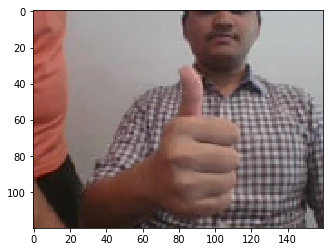

In [4]:
#Examine an image
img_path = 'Project_data/train/'+ train_doc[5].split(';')[0]
img = imread(img_path + '/'+ os.listdir(img_path)[0])
plt.imshow(img)
print(img.shape)

<a id="2"></a>
## 2. Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size, frames_per_video, frames_red, img_x, img_y, norm_technique='minmax'):
    
    # General Generator function that can be used for other textual data also
    # Source_path is root data directory
    # Folder_list - .csv file that we pass (traninng\validation)
    # Batch_size -  size of the batch
    # frames_per_video - Number of image indexes that will be used
    # frames_red - Frame reduction factor , 1 : keeps all frames, 2 : keeps alternate images
    # img_x ,img_y - Resolution of final image
    # norm_technique - Image Normalisation Technique
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = np.arange(0,frames_per_video, frames_red) 
    num_imgs = len(img_idx)

    while True:
        t = np.random.permutation(folder_list)
        
        num_full_batches = int(len(folder_list)/batch_size)
        num_batches = num_full_batches if (len(folder_list)%batch_size == 0) else (num_full_batches+1)
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            # Update batch_size to handle remaining datapoints which are left after full batches
            if (num_batches == (batch + 1) and (len(folder_list) > num_full_batches * batch_size)):
                data_points = len(folder_list) - (num_full_batches * batch_size)
            else:
                data_points = batch_size
            
            batch_data = np.zeros((data_points, num_imgs, img_x, img_y, 3)) #3 is the number of channels RGB
            batch_labels = np.zeros((data_points,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(data_points): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    height, width , channel = image.shape

                    # CROP : Resulting in low validation accuracy
                    # if size of image is 160x120, we will need to crop it make is AxA image
                    #if height != width:
                    #    image = image[:120, 20:140,:]

                    # RESIZE
                    # We can now resize all images to have same dimension 
                    #image = cv2.resize(image, (img_x, img_y))
                    image = skimage.transform.resize(image,(img_x,img_y))

                    # NORMALIZATION
                    #Create Batch Data Channelwise (RGB):
                    if norm_technique == 'minmax':
                        image = (image - np.min(image))/(np.max(image)- np.min(image))
                    else :
                        image = (image - np.percentile(image,5))/(np.percentile(image,95) - np.percentile(image,5))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]#normalise and feed in the image
     
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

<a id="3"></a>
##  3. Architecture 1 - CNN + GRU-RNN 

<a id="3.1"></a>
### 3.1 Model 1: CNN + GRU-RNN 
Batch size: 30 Epochs: 25 <br> 
Image size: 100 * 100, Frames per video : 15, Optimiser : Adam, Normalization : minmax

In [8]:
# Generator parameters
num_epochs = 25
batch_size = 30
frames_per_video = 30
frame_red = 2
img_x = 100
img_y = 100
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
opt = Adam(0.001)

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
# num_epochs = 20
# t,v = 30,20
# train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
# val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
# num_train_sequences = len(train_doc)
# num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red, img_x, img_y, 3)

# build the model
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

## GRU based RNN with softmax
model.add(GRU(128, return_sequences=False))
model.add(Dense(num_classes, activation='softmax'))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)
#For initial experiments not checkpointing
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y, norm)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y, norm)

# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
        

#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 15, 50, 50, 8)     224       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 50, 50, 16)    1168      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 25, 25, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 12, 12, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 12, 12, 64)    18496     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 6, 6, 64)      0         
__________

<a id="3.2"></a>
### 3.2 Model 2: CNN + GRU-RNN with Normalization technique : percentile
Batch size: 30 Epochs: 25 <br> 
Image size: 100 * 100, Frames per video : 15, Optimiser : Adam

In [7]:
# Generator parameters
num_epochs = 25
batch_size = 30
frames_per_video = 30
frame_red = 2
img_x = 100
img_y = 100
norm = 'percentile'

#Model Architecture
num_classes = 5

#optimizer
opt = Adam(0.001)

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
# num_epochs = 20
# t,v = 30,20
# train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
# val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
# num_train_sequences = len(train_doc)
# num_val_sequences = len(val_doc)


# Input shape
input_shape=(frames_per_video//frame_red, img_x, img_y, 3)

# build the model
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

## GRU based RNN with softmax
model.add(GRU(128, return_sequences=False))
model.add(Dense(num_classes, activation='softmax'))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)
#For initial experiments not checkpointing
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y, norm)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y, norm)

# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
        

#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 50, 50, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 50, 50, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 25, 25, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 12, 12, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 12, 12, 64)    18496     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 6, 6, 64)      0         
__________

<a id="3.3"></a>
### Model 3: CNN + GRU-RNN with Optimiser : Adadelta
Batch size: 30 Epochs: 35 <br> 
Image size: 100 * 100, Frames per video : 15, Normalization : minmax

In [15]:
# Generator parameters
num_epochs = 35
batch_size = 30
frames_per_video = 30
frame_red = 2
img_x = 100
img_y = 100
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
opt = optimizers.Adadelta()

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
# num_epochs = 20
# t,v = 30,20
# train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
# val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
# num_train_sequences = len(train_doc)
# num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red, img_x, img_y, 3)

# build the model
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

## GRU based RNN with softmax
model.add(GRU(128, return_sequences=False))
model.add(Dense(num_classes, activation='softmax'))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)

ES = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
#For initial experiments not checkpointing
#callbacks_list = [checkpoint, LR, ES]
callbacks_list = [LR, ES]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y)

# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 15, 50, 50, 8)     224       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 50, 50, 16)    1168      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 25, 25, 32)    4640      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 15, 12, 12, 32)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 15, 12, 12, 64)    18496     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 15, 6, 6, 64)      0         
__________

<a id="3.4"></a>
### 3.4 Model 4: CNN + GRU-RNN - Image size changes
Batch size: 30 Epochs: 35 <br> 
Image size: 120 * 120, Frames per video : 30, normalization : minmax, Optimizer : Adadelta

In [16]:
# Generator parameters
num_epochs = 35
batch_size = 30
frames_per_video = 30
frame_red = 1
img_x = 120
img_y = 120
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
opt = optimizers.Adadelta()

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
# num_epochs = 20
# t,v = 30,20
# train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
# val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
# num_train_sequences = len(train_doc)
# num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red, img_x, img_y, 3)

# build the model
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

## GRU based RNN with softmax
model.add(GRU(128, return_sequences=False))
model.add(Dense(num_classes, activation='softmax'))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)

ES = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
#For initial experiments not checkpointing
#callbacks_list = [checkpoint, LR, ES]
callbacks_list = [LR, ES]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y)

# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 30, 15, 15, 64)    18496     
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 7, 7, 64)      0         
__________

<a id="4"></a>
##  4. Architecture 2 - Transfer Learning + GRU-RNN Model 

<a id="4.1"></a>
### 4.1 Model 5: VGG16 Transfer Learning + GRU-RNN

In [8]:
# Generator parameters
num_epochs = 35
batch_size = 30
frames_per_video = 30
frame_red = 1
img_x = 120
img_y = 120
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
opt = optimizers.Adadelta()

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
# num_epochs = 20
# t,v = 30,20
# train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
# val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
# num_train_sequences = len(train_doc)
# num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red, img_x, img_y, 3)

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_x, img_y, 3))

for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(vgg, input_shape= input_shape ))
model.add(TimeDistributed(Flatten()))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=False))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = "softmax"))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_transfer_rnn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)
#For initial experiments on lower data size no need to checkpoint
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y)

# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 30, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 4608)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 128)           589952    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________

<a id="4.2"></a>
### 4.2 Model 6: RestNet50 Transfer Learning + GRU-RNN
Batch size: 30 Epochs: 35 <br> 
Image size: 200 * 200 (ResNet restriction for image size greater than 197x197) <br>
Frames per video : 30, Normalization : minmax, Optimizer:Adadelta

In [11]:
# Generator parameters
num_epochs = 35
batch_size = 30
frames_per_video = 30
frame_red = 1
img_x = 200
img_y = 200
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
opt = optimizers.Adadelta()

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
num_epochs = 20
t,v = 30,20
train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red, img_x, img_y, 3)

# Import a RESNET model, consider input image with shape (img_x, img_y, 3)
base = ResNet50(include_top=False, weights='imagenet', input_shape=(img_x,img_y,3))

# Mark only four last layers as trainable
for layer in base.layers[:-2]:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(base, input_shape= input_shape ))
model.add(TimeDistributed(Flatten()))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(GRU(64, return_sequences=False))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = "softmax"))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_transfer_rnn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)
#For initial experiments on lower data size no need to checkpoint
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y)

# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 30, 7, 7, 2048)    23587712  
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 100352)        0         
_________________________________________________________________
dense_13 (Dense)             (None, 30, 64)            6422592   
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
__________

<a id="5"></a>
## 5. Architecture 3 - 3D CNN 

<a id="5.1"></a>
### 5.1 Model 7: 3D CNN 
Batch size: 30 Epochs: 25 <br> 
Image size: 100 * 100, frames per video : 15, normalization : minmax, optimizer : Adadelta

In [8]:
# Generator parameters
num_epochs = 25
batch_size = 30
frames_per_video = 30
frame_red = 2
img_x = 100
img_y = 100
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
opt = optimizers.Adadelta()

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
# num_epochs = 20
# t,v = 30,20
# train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
# val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
# num_train_sequences = len(train_doc)
# num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red, img_x, img_y, 3)

model = Sequential()
model.add(Conv3D(8, (5,5,5), activation='relu', padding = 'same', input_shape=input_shape))
model.add(Conv3D(16, (5,5,5), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))

model.add(Conv3D(32, (5,5,5), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))

model.add(Conv3D(64, (5,5,5), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_conv3d' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)

#ES = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
#For initial experiments not checkpointing
#callbacks_list = [checkpoint, LR, ES]
callbacks_list = [LR]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y)

# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 100, 100, 8)   3008      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 100, 100, 16)  16016     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 50, 50, 32)     64032     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 25, 25, 32)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 3, 25, 25, 64)     256064    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 12, 12, 64)     0         
__________

<a id="5.2"></a>
###  5.2 Model 8: 3D CNN  - Kernel, dropouts and Image size change
Batch size: 30 Epochs: 35 <br> 
Image size: 120 * 120, frames per video : 30, normalization : minmax, optimizer : Adadelta

In [15]:
# Generator parameters
num_epochs = 25
batch_size = 30
frames_per_video = 30
frame_red = 1
img_x = 120
img_y = 120
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
#opt = Adam(0.001)
opt = optimizers.Adadelta()

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
num_epochs = 20
t,v = 30,20
train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red,img_x,img_y,3)

# build the model
model = Sequential()

model.add(Conv3D(8, (3,3,3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2))) 

model.add(Conv3D(32, (1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
            
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
            
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(num_classes, activation='softmax'))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_conv3d_final' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)

callbacks_list = [checkpoint, LR]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y)

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
steps_per_epoch = math.ceil(num_train_sequences/batch_size)
validation_steps = math.ceil(num_val_sequences/batch_size)

#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_10 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 60, 60, 16)    64        
__________


Epoch 00018: saving model to model_conv3d_final_2020-03-3012_03_20.885493/model-00018-0.22212-0.96667-1.64847-0.35000.h5
Epoch 19/20
1/1 [==============================] - 7s 7s/step - loss: 0.2798 - categorical_accuracy: 0.9667 - val_loss: 1.5257 - val_categorical_accuracy: 0.3000

Epoch 00019: saving model to model_conv3d_final_2020-03-3012_03_20.885493/model-00019-0.27983-0.96667-1.52571-0.30000.h5
Epoch 20/20
1/1 [==============================] - 7s 7s/step - loss: 0.2074 - categorical_accuracy: 0.9333 - val_loss: 1.5269 - val_categorical_accuracy: 0.3500

Epoch 00020: saving model to model_conv3d_final_2020-03-3012_03_20.885493/model-00020-0.20736-0.93333-1.52686-0.35000.h5


## 3D CNN  Final Model
Batch size: 30 Epochs: 35 <br> 
Image size: 120 * 120, 30 frames per video, minmax normalization, Adadelta optimizer<br>
Refer to other architecture parameters at the top of the block

In [ ]:
# Generator parameters
num_epochs = 35
batch_size = 30
frames_per_video = 30
frame_red = 1
img_x = 120
img_y = 120
norm = 'minmax'

#Model Architecture
num_classes = 5

#optimizer
#opt = Adam(0.001)
opt = optimizers.Adadelta()

# Work on smaller dataset for initial experiments by randomly pick a subset of t for train v for validation
# num_epochs = 20
# t,v = 30,20
# train_doc = train_doc[ np.random.choice(train_doc.shape[0], t, replace=False)]
# val_doc = val_doc[ np.random.choice(val_doc.shape[0], v, replace=False)]
# num_train_sequences = len(train_doc)
# num_val_sequences = len(val_doc)

# Input shape
input_shape=(frames_per_video//frame_red,img_x,img_y,3)

# build the model
model = Sequential()

model.add(Conv3D(8, (3,3,3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2))) 

model.add(Conv3D(32, (1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
            
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
            
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(num_classes, activation='softmax'))

#compile and print the model summary
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#checkpoints and callbacks
model_name = 'model_conv3d_final' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, cooldown=5, verbose=1, mode='auto',min_delta=0.0001)

callbacks_list = [checkpoint, LR]

#create the generator for fit_generator
train_generator = generator(train_path, train_doc, batch_size, frames_per_video, frame_red, img_x, img_y)
val_generator = generator(val_path, val_doc, batch_size, frames_per_video, frame_red, img_x, img_y)

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
steps_per_epoch = math.ceil(num_train_sequences/batch_size)
validation_steps = math.ceil(num_val_sequences/batch_size)

#fit the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
__________

23/23 [==============================] - 126s 5s/step - loss: 0.1688 - categorical_accuracy: 0.9594 - val_loss: 0.8843 - val_categorical_accuracy: 0.7600

Epoch 00018: saving model to model_conv3d_final_2020-03-3015_03_38.826908/model-00018-0.17173-0.95777-0.88432-0.76000.h5
Epoch 19/35
23/23 [==============================] - 122s 5s/step - loss: 0.0834 - categorical_accuracy: 0.9527 - val_loss: 1.3221 - val_categorical_accuracy: 0.6400

Epoch 00019: saving model to model_conv3d_final_2020-03-3015_03_38.826908/model-00019-0.07428-0.96380-1.32206-0.64000.h5
Epoch 20/35
23/23 [==============================] - 122s 5s/step - loss: 0.0690 - categorical_accuracy: 0.9768 - val_loss: 1.0223 - val_categorical_accuracy: 0.7200

Epoch 00020: saving model to model_conv3d_final_2020-03-3015_03_38.826908/model-00020-0.07137-0.97587-1.02226-0.72000.h5
Epoch 21/35
23/23 [==============================] - 126s 5s/step - loss: 0.0342 - categorical_accuracy: 0.9913 - val_loss: 1.0655 - val_categorical